In [1]:
from keras.layers import Input, merge
from keras.models import Model,Sequential
from layers import VGGNormalize,ReflectionPadding2D,Denormalize,conv_bn_relu,res_conv,dconv_bn_nolinear
from loss import dummy_loss,StyleReconstructionRegularizer,FeatureReconstructionRegularizer,TVRegularizer

import nets

%matplotlib inline

%reload_ext autoreload

%autoreload 2


Using TensorFlow backend.


* Input 3 × 256 × 256
* Reflection Padding (40 × 40) 3 × 336 × 336
* 32 × 9 × 9 conv, stride 1 32 × 336 × 336
* 64 × 3 × 3 conv, stride 2 64 × 168 × 168
* 128 × 3 × 3 conv, stride 2 128 × 84 × 84
* Residual block, 128 filters 128 × 80 × 80
* Residual block, 128 filters 128 × 76 × 76
* Residual block, 128 filters 128 × 72 × 72
* Residual block, 128 filters 128 × 68 × 68
* Residual block, 128 filters 128 × 64 × 64
* 64 × 3 × 3 conv, stride 1/2 64 × 128 × 128
* 32 × 3 × 3 conv, stride 1/2 32 × 256 × 256
* 3 × 9 × 9 conv, stride 1 3 × 256 × 256

In [2]:


img_width, img_height = 256,256

net = nets.image_transform_net(img_width,img_height)
# print model.summary() 

#if tranning

model = nets.loss_net(net.output,net.input,img_width,img_height)

model.summary()

VGG Model weights loaded.
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
inputnormalize_1 (InputNormalize (None, 256, 256, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
reflectionpadding2d_1 (Reflectio (None, 336, 336, 3)   0           inputnormalize_1[0][0]           
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 336, 336, 32)  7808        reflectionpadding2d_1[0][0]      
_________________________________________________________________

In [ ]:
from img_util import deprocess_image
from scipy.misc import imsave
from IPython.core.display import Image, display 

def display_val_img(i,x):
    # save current generated image
    img = x #deprocess_image(x)
    fname = 'output_%d.png' % i
    imsave(fname, img)
    print('Image saved as', fname)
   

    display(Image(fname)) 
    

Found 82785 images belonging to 2 classes.
7.30861e+09 15.7111439705
('epoc: ', 0)
('Image saved as', 'output_0.png')


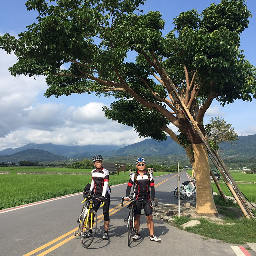

('Image saved as', 'output_0.png')


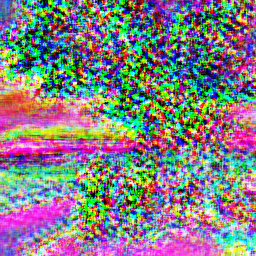

1.30369e+09 12.8212049007
4.41993e+09 11.4328100681
3.54142e+09 11.4698278904
2.89266e+09 11.4388511181
('epoc: ', 200)
('Image saved as', 'output_200.png')


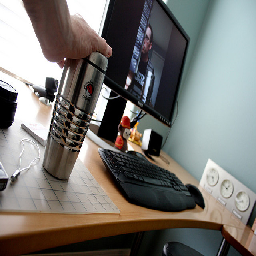

('Image saved as', 'output_200.png')


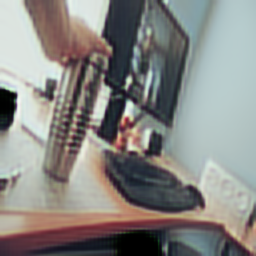

3.23324e+09 11.6812551022
2.85723e+09 11.4715559483
4.32357e+09 11.5410430431
3.45525e+09 11.519562006
('epoc: ', 400)
('Image saved as', 'output_400.png')


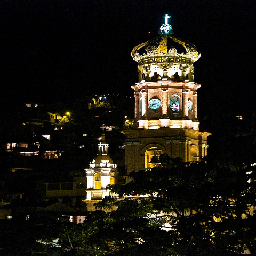

('Image saved as', 'output_400.png')


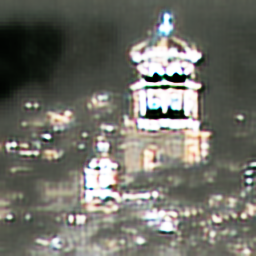

2.50037e+09 11.6753201485
9.80356e+08 11.5061719418
1.90114e+09 11.4997148514
2.47987e+09 11.3976500034
('epoc: ', 600)
('Image saved as', 'output_600.png')


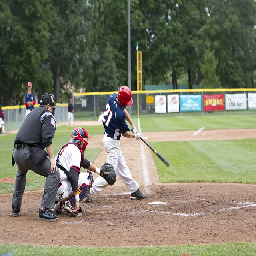

('Image saved as', 'output_600.png')


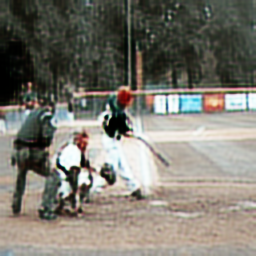

1.82475e+09 11.7391781807
1.79623e+09 11.4698069096
2.02182e+09 11.4517049789
1.49942e+09 11.4634058475
('epoc: ', 800)
('Image saved as', 'output_800.png')


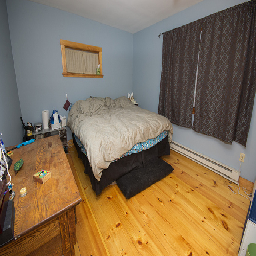

('Image saved as', 'output_800.png')


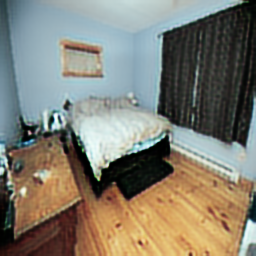

1.13697e+09 11.6809370518
1.10504e+09 11.4907560349
2.09028e+09 11.4470739365


In [ ]:
from keras.optimizers import Adam, SGD,Nadam,Adadelta
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import time
import numpy as np

from keras.callbacks import TensorBoard


nb_epoch = 82785 *2
train_batchsize =  1
train_image_path = "images/train/"

learning_rate = 1e-3 #1e-3
optimizer = Adam() # Adam(lr=learning_rate,beta_1=0.99)

model.compile(optimizer,  dummy_loss)  # Dummy loss since we are learning from regularizes

datagen = ImageDataGenerator()

dummy_y = np.zeros((train_batchsize,img_width,img_height,3)) # Dummy output, not used since we use regularizers to train


#tbCallBack = TensorBoard(log_dir='/Graph', histogram_freq=0, write_graph=True, write_images=True)



#model.load_weights('weights.h5',by_name=False)


i=0
t1 = time.time()
for x in datagen.flow_from_directory(train_image_path, class_mode=None, batch_size=train_batchsize,
    target_size=(img_width, img_height), shuffle=False):    
    if i > nb_epoch:
        break

    hist = model.train_on_batch(x, dummy_y)
    
    if i % 50 == 0:
        print  hist,(time.time() -t1)
        t1 = time.time()
    
    if i % 200 == 0:
        print("epoc: ", i)
        val_x = net.predict(x)
#         val_x = net.predict(x)
        display_val_img(i, x[0])
        display_val_img(i, val_x[0])
        model.save_weights('weights.h5')

    i+=1
    
    